(Numpyro Example)=

# An Introduction into NumPyro

This notebook shows an example analysis of an archival data set from VLT/FORS2 using NumPyro for inference.

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os.path

%load_ext autoreload
%autoreload 2

x_l = np.load(os.path.join("sample_data", "WASP31b_FORS2_600B", "x_l.npy"))
x_t = np.load(os.path.join("sample_data", "WASP31b_FORS2_600B", "x_t.npy"))
Y = np.load(os.path.join("sample_data", "WASP31b_FORS2_600B", "Y.npy"))
ld_coeff = np.load(os.path.join("sample_data", "WASP31b_FORS2_600B", "ld_coeff.npy"))

N_l = x_l.shape[-1]
N_t = x_t.shape[-1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
x_l = np.load(os.path.join("sample_data", "WASP31b_FORS2_600B", "x_l.npy"))
x_t = np.load(os.path.join("sample_data", "WASP31b_FORS2_600B", "x_t.npy"))
Y = np.load(os.path.join("sample_data", "WASP31b_FORS2_600B", "Y.npy"))

N_t = x_t.size

x_l = x_l[:5]
ld_coeff = ld_coeff[:5, :]
x_t = x_t[:-(N_t % 5)]
N_t = x_t.size

bin_mat = np.kron(np.eye(N_t //5), np.ones(5))/5.
Y = Y[:5, :N_t]

x_t = bin_mat @ x_t
Y = (bin_mat @ Y.T).T

N_l = x_l.shape[-1]
N_t = x_t.shape[-1]

In [3]:
from luas.kernels import squared_exp
from luas import LuasKernel

def Kl_fn(hp, x_l1, x_l2, wn = True):
    Kl = jnp.power(10, 2*hp["h_CM"])*squared_exp(x_l1, x_l2, jnp.power(10, hp["l_l_CM"])) + jnp.diag(jnp.power(10, 2*hp["h_WSS"]))
    return Kl

def Kt_fn(hp, x_t1, x_t2, wn = True):
    return squared_exp(x_t1, x_t2, jnp.power(10, hp["l_t"]))

def Sl_fn(hp, x_l1, x_l2, wn = True):
    Sl = jnp.power(10, 2*hp["h_HFS"])*squared_exp(x_l1, x_l2, jnp.power(10, hp["l_l_HFS"]))
    if wn:
        Sl += jnp.diag(jnp.power(10, 2*hp["sigma"]))

    return Sl

def St_fn(p, x_t1, x_t2, wn = True):
    return jnp.eye(x_t1.shape[-1])
St_fn.decomp = "diag"

kernel = LuasKernel(Kl_fn, Kt_fn, Sl_fn, St_fn, use_stored_results = False)

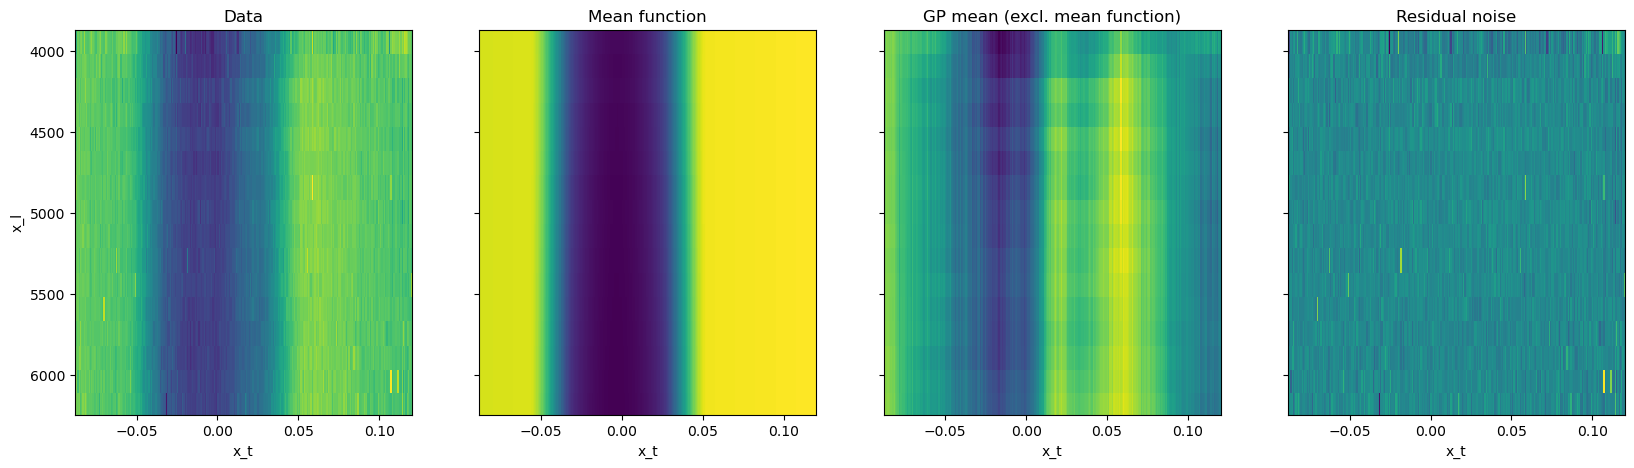

23193.027819157724


In [4]:
from luas import GP
from luas.exoplanet import transit_2D, ld_from_kipping, ld_to_kipping

u1, u2 = ld_to_kipping(ld_coeff[:, 0], ld_coeff[:, 1])

p_initial = {"T0":-0.0021*jnp.ones(1), "P":3.4059095*jnp.ones(1), "a":8.16*jnp.ones(1), "b":0.771*jnp.ones(1), "d":0.015*jnp.ones(N_l), "u1":u1, "u2":u2,
     "Foot":jnp.ones(N_l)*0.9995, "Tgrad":jnp.ones(N_l)*0.0002, "h_CM":1.5e-3*jnp.ones(1), "l_t":0.011*jnp.ones(1), "l_l_CM":10000*jnp.ones(1), "sigma":1.2e-3*jnp.ones(N_l),
                  "h_WSS":2e-4*jnp.ones(N_l), "h_HFS":3e-4*np.ones(1), "l_l_HFS":1000*jnp.ones(1)}

for par in ["h_CM", "l_t", "l_l_CM", "sigma", "h_WSS", "h_HFS", "l_l_HFS"]:
    p_initial[par] = jnp.log10(p_initial[par])

prior_values = {"a":8.19, "b":0.761}
prior_std = {"a":0.1, "b":0.018}

def logPrior(p):
    logPrior = -0.5*((p["a"] - prior_values["a"])/prior_std["a"])**2
    logPrior += -0.5*((p["b"] - prior_values["b"])/prior_std["b"])**2

    c1, c2 = ld_from_kipping(p["u1"], p["u2"])
    logPrior += (-0.5*((c1 - ld_coeff[:N_l, 0])/0.1)**2).sum()
    logPrior += (-0.5*((c2 - ld_coeff[:N_l, 1])/0.1)**2).sum()

    return logPrior.sum()

gp = GP(kernel, x_l, x_t, mf = transit_2D, logPrior = logPrior)

gp.plot(p_initial, Y)
print(gp.logP(p_initial, Y))

In [5]:
import numpyro
import numpyro.distributions as dist
from luas.numpyro_ext import LuasGP
from copy import deepcopy

param_bounds = {"T0":[np.array([-0.01]), np.array([0.01])],
                "d":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "sigma":[np.array([-5.]*N_l), np.array([-2.]*N_l)],
                "h_WSS":[np.array([-6.]*N_l), np.array([-2.]*N_l)],
                "h_CM":[np.array([-6.]*1), np.array([-2.]*1)],
                "l_l_CM":[np.array([np.log10(np.diff(x_l).min())]), np.array([np.log10(50*(x_l.max() - x_l.min()))])],
                "h_HFS":[np.array([-6.]), np.array([-2.])],
                "l_l_HFS":[np.array([np.log10(np.diff(x_l).min())]), np.array([np.log10(50*(x_l.max() - x_l.min()))])]}


def transit_model(Y):
    
    p = deepcopy(p_initial)
    
    p["T0"] = numpyro.sample("T0", dist.Uniform(low = param_bounds["T0"][0], high = param_bounds["T0"][1]))
    p["d"] = numpyro.sample("d", dist.Uniform(low = param_bounds["d"][0], high =param_bounds["d"][1]))
    p["h_CM"] = numpyro.sample("h_CM", dist.Uniform(low = param_bounds["h_CM"][0], high = param_bounds["h_CM"][1]))
    p["l_l_CM"] = numpyro.sample("l_l_CM", dist.Uniform(low = param_bounds["l_l_CM"][0], high = param_bounds["l_l_CM"][1]))
    p["h_HFS"] = numpyro.sample("h_HFS", dist.Uniform(low = param_bounds["h_HFS"][0], high = param_bounds["h_HFS"][1]))
    p["l_l_HFS"] = numpyro.sample("l_l_HFS", dist.Uniform(low = param_bounds["l_l_HFS"][0], high = param_bounds["l_l_HFS"][1]))
    p["h_WSS"] = numpyro.sample("h_WSS", dist.Uniform(low = param_bounds["h_WSS"][0], high = param_bounds["h_WSS"][1]))
    p["sigma"] = numpyro.sample("sigma", dist.Uniform(low = param_bounds["sigma"][0], high = param_bounds["sigma"][1]))
    
    p["l_t"] = numpyro.sample("l_t", dist.ImproperUniform(dist.constraints.real, (), event_shape = (1,)))
    p["a"] = numpyro.sample("a", dist.ImproperUniform(dist.constraints.real, (), event_shape = (1,)))
    p["b"] = numpyro.sample("b", dist.ImproperUniform(dist.constraints.real, (), event_shape = (1,)))
    p["u1"] = numpyro.sample("u1", dist.ImproperUniform(dist.constraints.real, (), event_shape = (N_l,)))
    p["u2"] = numpyro.sample("u2", dist.ImproperUniform(dist.constraints.real, (), event_shape = (N_l,)))
    p["Foot"] = numpyro.sample("Foot", dist.ImproperUniform(dist.constraints.real, (), event_shape = (N_l,)))
    p["Tgrad"] = numpyro.sample("Tgrad", dist.ImproperUniform(dist.constraints.real, (), event_shape = (N_l,)))

    numpyro.sample("obs", LuasGP(gp = gp, p = p, hessian = True), obs = Y)

/Users/mark/miniforge3/envs/pymc4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer.initialization import init_to_value
from jax import random

optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = AutoLaplaceApproximation(transit_model, init_loc_fn = init_to_value(values=p_initial))
svi = SVI(transit_model, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 5000, Y)
params = svi_result.params
p_fit = guide.median(params)

p_opt = deepcopy(p_initial)
p_opt.update(p_fit)

100%|█| 5000/5000 [02:39<00:00, 31.33it/s, init loss: -23070.5595, avg. loss [47


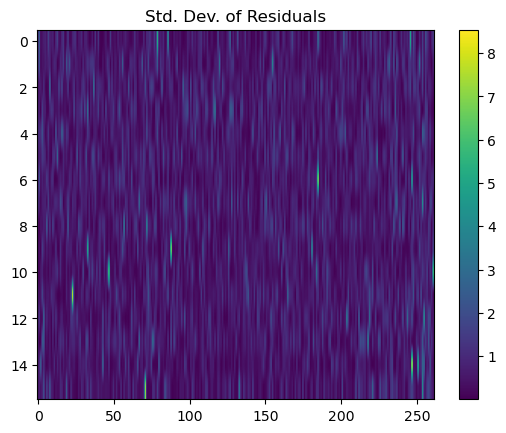

Outliers removed =  15


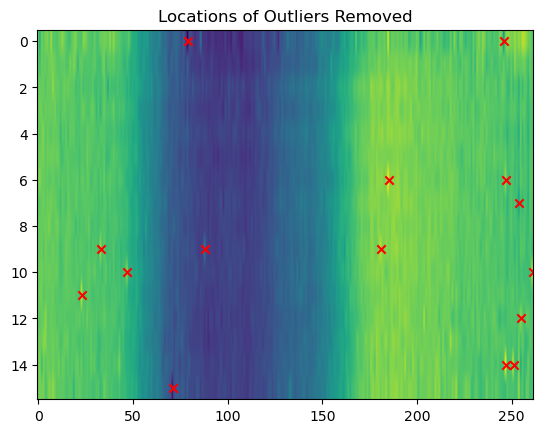

In [7]:
Y_clean = gp.sigma_clip(p_opt, Y, 4.)

In [8]:
guide = AutoLaplaceApproximation(transit_model, init_loc_fn = init_to_value(values=p_opt))
svi = SVI(transit_model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, Y_clean)
params = svi_result.params

p_fit2 = guide.median(params)
p_opt2 = deepcopy(p_opt)
p_opt2.update(p_fit2)

100%|█| 1000/1000 [00:40<00:00, 24.80it/s, init loss: -24490.0852, avg. loss [95


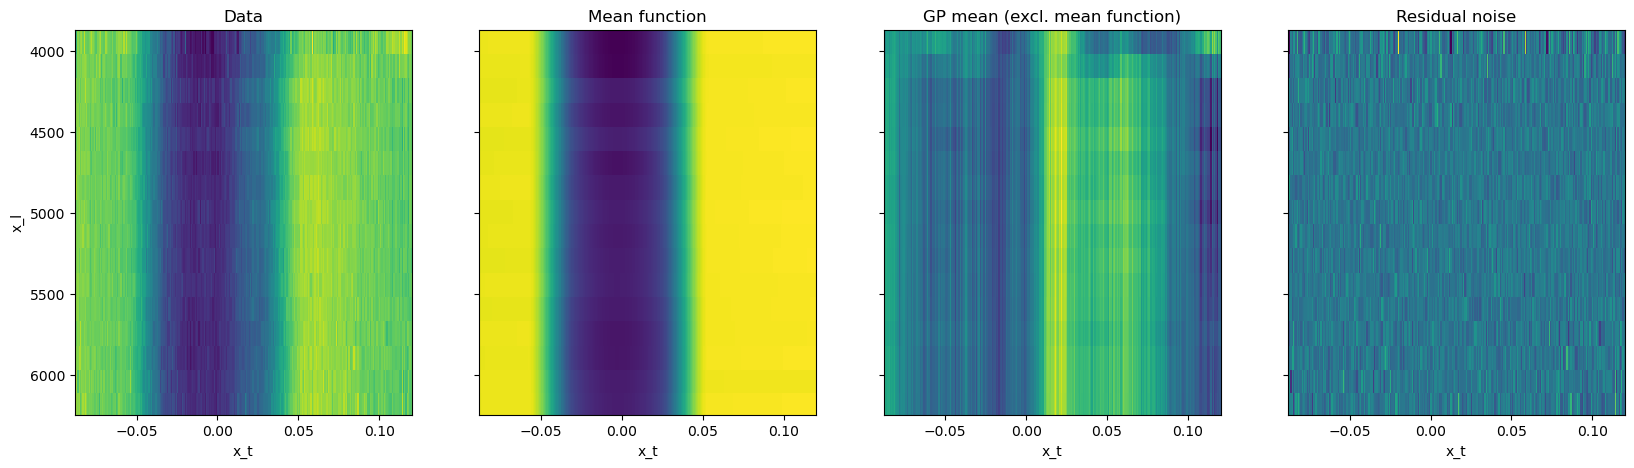

In [9]:
gp.plot(p_opt2, Y_clean)

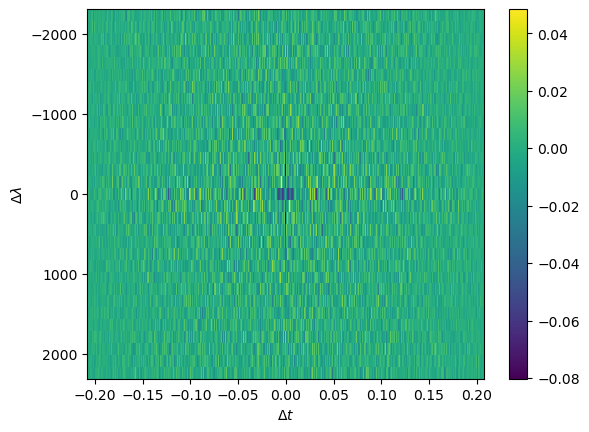

In [10]:
autocorr = gp.autocorrelate(p_opt2, Y_clean)

In [11]:
import pickle

def save_dict(dict_to_save, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dict_to_save, f)

save_dict(p_opt2, os.path.join("sample_data", "p_opt2.pkl"))
np.save(os.path.join("sample_data", "Y_clean.npy"), Y_clean)

In [12]:
import pickle

def load_dict(filename):
    with open(filename, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

p_opt2 = load_dict(os.path.join("sample_data", "p_opt2.pkl"))
Y_clean = np.load(os.path.join("sample_data", "Y_clean.npy"))

In [13]:
cov_mat, param_order = gp.laplace_approx_with_bounds(p_opt2, Y_clean, param_bounds, regularise = True, return_array = True, fixed_vars = ["P"], large = False)

Initial number of negative values on diagonal of covariance matrix = 0
Corresponding to parameters: {}.
Remaining number of negative values = 0.


In [ ]:
from numpyro.infer import MCMC, NUTS
from jax import random

rng_key, rng_key_predict = random.split(random.PRNGKey(0))

kernel_NUTS = NUTS(transit_model, init_strategy = init_to_value(values = p_opt2),  inverse_mass_matrix = cov_mat, 
                   adapt_mass_matrix=False, dense_mass = True,
                   find_heuristic_step_size = False, regularize_mass_matrix = False)

mcmc = MCMC(
    kernel_NUTS,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    thinning=1,
    progress_bar=True,
)

mcmc.run(rng_key, Y_clean)

/var/folders/lp/chmp1tb92f5_x_wdckqwk34c0000gn/T/ipykernel_13212/851120466.py:10: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample:  51%|▌| 1018/2000 [10:02<06:29,  2.52it/s, 15 steps of size 2.93e-01. ac

In [ ]:
import arviz as az
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

idata = az.from_numpyro(mcmc)

# Print a summary of the samples
df_summary = az.summary(idata, round_to = 6)

df_summary

In [ ]:
trace_plot = az.plot_trace(idata, divergences = None)
plt.tight_layout()

In [ ]:
import corner

params = ["T0", "a", "b", "d", "h_CM", "l_l_CM", "l_t", "h_HFS", "l_l_HFS"]

N_chains = idata.posterior.dims["chain"]

if N_chains > 1:
    idata_corner1 = idata.sel(chain=list(range(N_chains//2)))
    idata_corner2 = idata.sel(chain=list(range(N_chains//2, N_chains)))

    fig1 = corner.corner(idata_corner1, smooth = 0.4, var_names = params)
    fig2 = corner.corner(idata_corner2, quantiles=[0.16, 0.5, 0.84], title_fmt = None, title_kwargs={"fontsize": 23}, label_kwargs={"fontsize": 23}, show_titles=True,
                         smooth = 0.4, color = "r", fig = fig1, top_ticks = True, max_n_ticks = 2, labelpad = 0.16, var_names = params)
else:
    fig = corner.corner(idata_corner, quantiles=[0.16, 0.5, 0.84], title_fmt = None, title_kwargs={"fontsize": 23}, label_kwargs={"fontsize": 23}, show_titles=True,
                         smooth = 0.4, color = "k", top_ticks = True, max_n_ticks = 2, labelpad = 0.16, var_names = params)